# Supervised Learning Final Project

Diabetes is a chronic condition that occurs when the pancreas can no longer make insulin, or the body cannot effectively use insulin. Insulin is a hormone created in the pancreas that to move glucose into cells in the body. Glucose is a source of energy for the body. A person with diabetes is unable to control the levels of glucose in their blood. High levels of glucose over a long term is associated with organ failure and other damage to the body. As per [this report](https://idf.org/media/uploads/2024/06/IDF-Annual-Report-2023.pdf) from the International Diabetes Federation, an estimated 540 million people live with diabetes.

Early diabetes detection and prediction is an important tool to prevent diabetes. While there are several modern tests/features that can be used for diabetes detection, we will use some of the historically common ones that are cheaper and readily available. e.g. BMI, Glucose, Insulin, Age etc.

New research has shown that data preprocessed with Recursive Feature Elimination(RFE) and methods like eXtreme Gradient Boosting(XGBoost) and Stacking can provide a higher performance compared to Random Forest classifiers. The goal of these project is to explore the improvement in accuracy with these methods.

In [3]:
%pip install pandas numpy matplotlib seaborn scikit-learn xgboost kagglehub

import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from kagglehub import KaggleDatasetAdapter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from xgboost import XGBClassifier

Note: you may need to restart the kernel to use updated packages.


## Data

For this project, we will use the Pima Indians Diabetes Dataset made available by UCI Machine Learning on Kaggle. This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage. 

In [4]:
# Download latest version
data = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "uciml/pima-indians-diabetes-database",
  "diabetes.csv",
)
print(data.head())
print(data.info())

/var/folders/mp/vmnrbyxx37d22qffx8lh76nc0000gn/T/ipykernel_12115/2508552562.py:2: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  data = kagglehub.load_dataset(


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768

## Data Cleaning
The small number of records and the constraints mentioned in the previous section can skew the data and affect the predictions.

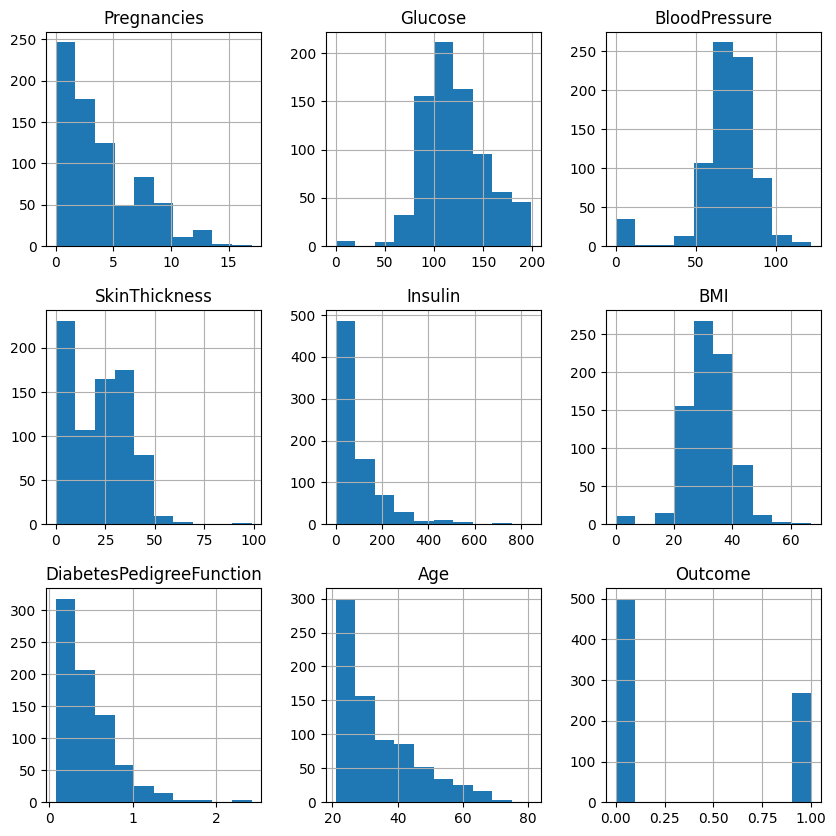

In [5]:
# Find distribution of target variable
data.hist(figsize = (10,10))
plt.show()

### Handling zero values
As shown on the graph, several features in the dataset have an impossible zero value. e.g. Glucose, Blood Pressure and BMI. These seem to be missing values that need to be imputed. We will impute these values using the median value of these columns

In [6]:
# Replace zero values with median
zero_columns = ['Glucose', 'BloodPressure', 'BMI', 'SkinThickness', 'Insulin']
for col in zero_columns:
    data[col] = data[col].replace(0, data[col].median())

print(data.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35     30.5  33.6   
1            1       85             66             29     30.5  26.6   
2            8      183             64             23     30.5  23.3   
3            1       89             66             23     94.0  28.1   
4            0      137             40             35    168.0  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


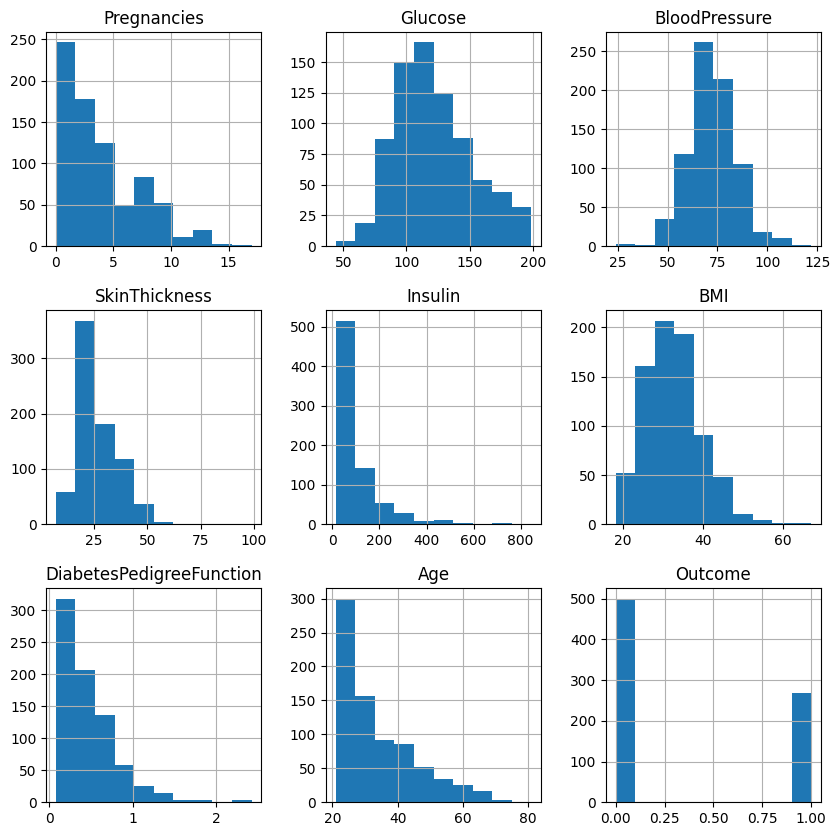

In [7]:
# Histplot with cleaned data
data.hist(figsize = (10,10))
plt.show()

## Exploratory Data Analysis

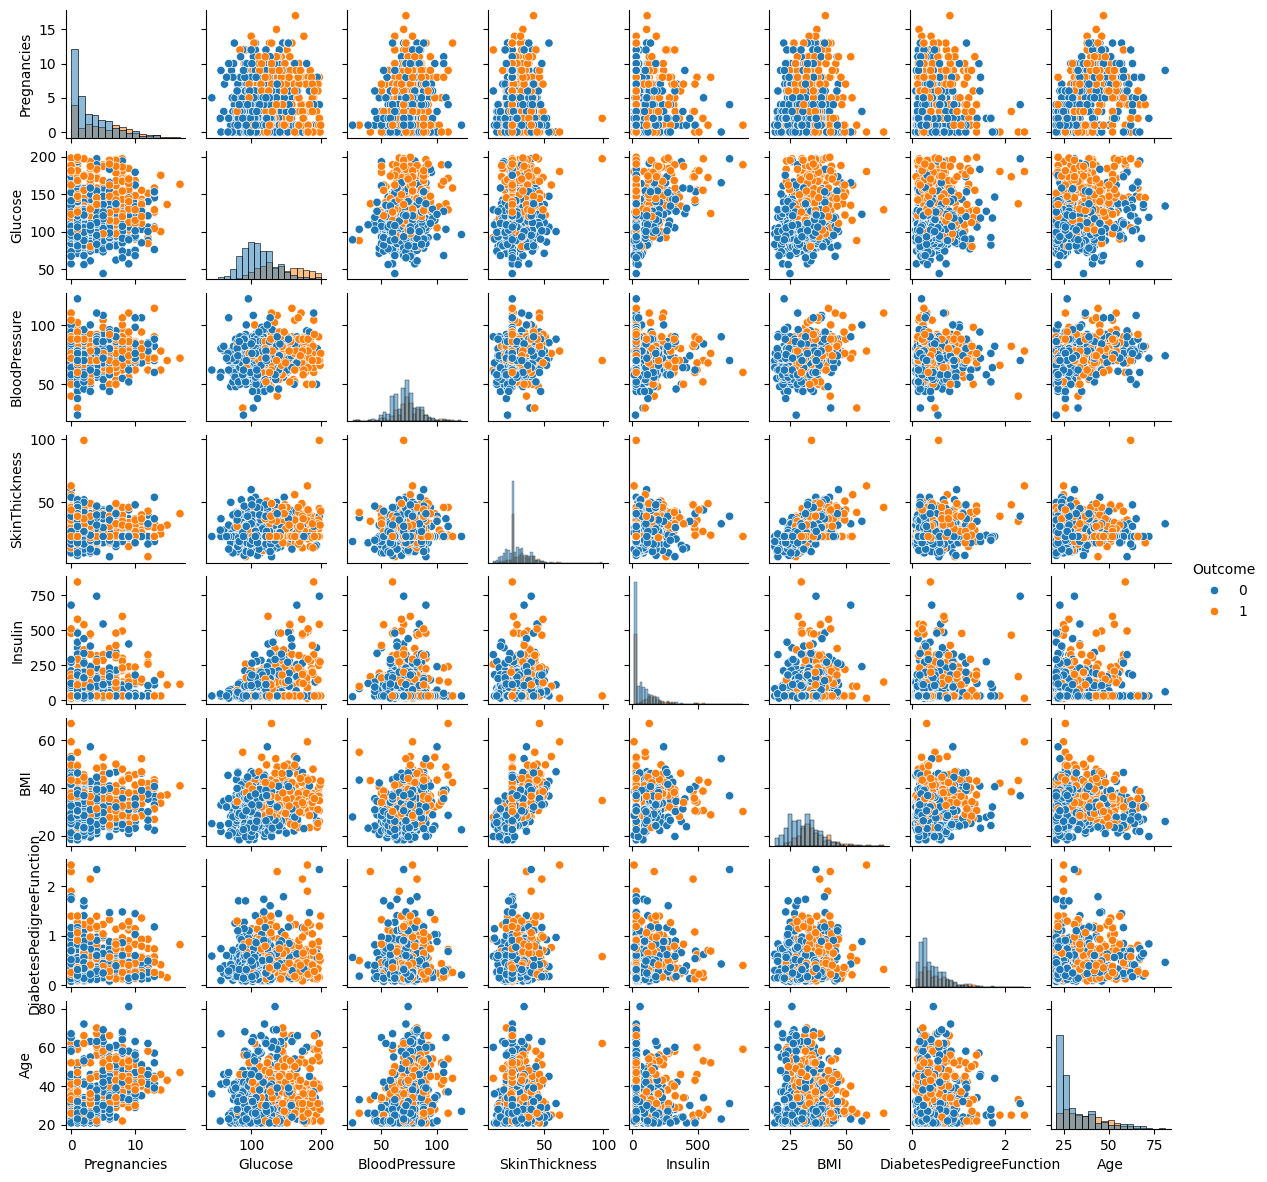

In [8]:
sns.pairplot(data, hue='Outcome', diag_kind='hist', height=1.5)
plt.show()

### Pairplot insights
- A counterintuitive finding is that the Glucose and Insulin are not linearly related.
- The pairplot also shows that BMI and Skin Thickness are correlated and therefore only one of them might be necessary for prediction

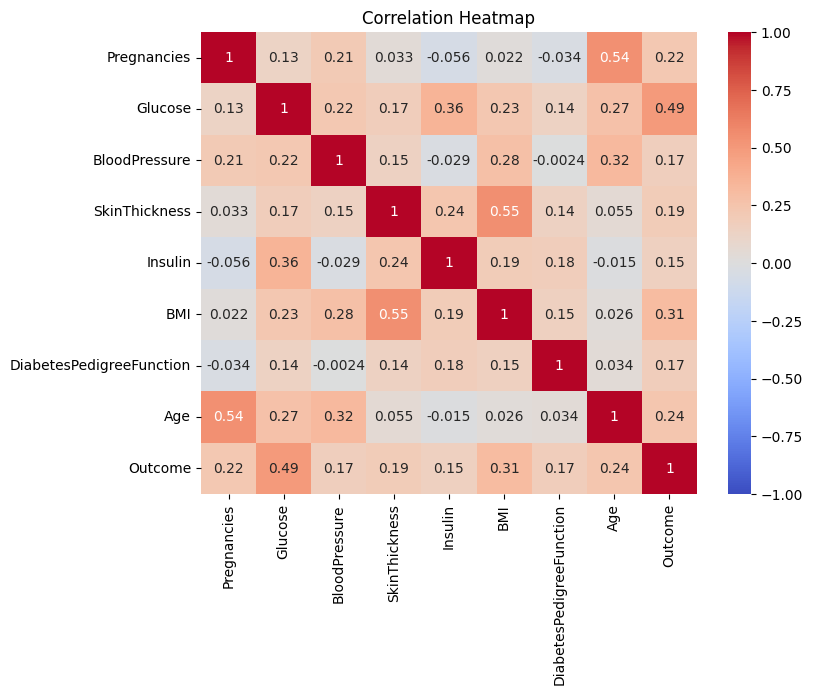

In [9]:
corr_matrix = data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap')
plt.show()

### Correlation Heatmap insights
- Outcomes are highly correlated to Glucose, BMI and Age. Intuitively, these should be the top three predictors for the models.
- Insulin, Blood Pressure and DiabetesPedigreeFunction are poor predictors becuase of their low correlation

## Models

Before applying the models, we need to scale the data to ensure that the features are on the same scale before they are selected using a Feature Selector.

In [10]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Recursive Feature Elimination using Logistic Regression as the base estimator
We will now use the RFE available in scikit-learn to select 4 features using recursive feature elimination. The features that provide the highest accuracy will be chosen. The estimator used is Logistic Regression. We will then create a training and test sample that is derived based on these features

In [11]:
lr_model = LogisticRegression(random_state=42)
rfe = RFE(estimator=lr_model, n_features_to_select=4, step=1)
rfe.fit(X_train_scaled, y_train)

# Get the selected features
selected_features = X.columns[rfe.support_]
print("Selected Features by RFE:", selected_features)

# Create new datasets with only the selected features
X_train_rfe = rfe.transform(X_train_scaled)
X_test_rfe = rfe.transform(X_test_scaled)


Selected Features by RFE: Index(['Pregnancies', 'Glucose', 'BMI', 'Age'], dtype='object')


### Random Forest without Feature Selection


In [12]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy')
rf_grid.fit(X_train_scaled, y_train)
rf_best = rf_grid.best_estimator_

print("\nBest Random Forest Parameters (without feature selection):", rf_grid.best_params_)
print("Random Forest Performance (without feature selection):")
print(classification_report(y_test, rf_best.predict(X_test_scaled)))
print("Accuracy Score:", accuracy_score(y_test, rf_best.predict(X_test_scaled)))


Best Random Forest Parameters (without feature selection): {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Performance (without feature selection):
              precision    recall  f1-score   support

           0       0.82      0.81      0.81        99
           1       0.66      0.67      0.67        55

    accuracy                           0.76       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.76      0.76      0.76       154

Accuracy Score: 0.7597402597402597


### Random Forest with feature selection

In [13]:
rf_rfe_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy')
rf_rfe_grid.fit(X_train_rfe, y_train)
rf_rfe_best = rf_rfe_grid.best_estimator_

print("\nBest Random Forest Parameters (with feature selection):", rf_rfe_grid.best_params_)
print("Random Forest Performance (with feature selection):")
print(classification_report(y_test, rf_rfe_best.predict(X_test_rfe)))
print("Accuracy Score:", accuracy_score(y_test, rf_rfe_best.predict(X_test_rfe)))


Best Random Forest Parameters (with feature selection): {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Performance (with feature selection):
              precision    recall  f1-score   support

           0       0.82      0.79      0.80        99
           1       0.64      0.69      0.67        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.74       154
weighted avg       0.76      0.75      0.76       154

Accuracy Score: 0.7532467532467533


### XGBoost
XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that is widely used to solve many data science problems in a fast and accurate way. 

In [14]:
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}
xgb_grid = GridSearchCV(XGBClassifier(random_state=42), xgb_params, cv=5, scoring='accuracy')
xgb_grid.fit(X_train_scaled, y_train)
xgb_best = xgb_grid.best_estimator_

print("\nBest XGBoost Parameters:", xgb_grid.best_params_)
print("XGBoost Performance:")
print(classification_report(y_test, xgb_best.predict(X_test_scaled)))
print("Accuracy Score:", accuracy_score(y_test, xgb_best.predict(X_test_scaled)))


Best XGBoost Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
XGBoost Performance:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82        99
           1       0.69      0.64      0.66        55

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.74       154
weighted avg       0.76      0.77      0.76       154

Accuracy Score: 0.7662337662337663


### Stacking
Stacking is an ensemble machine learning method that can classify data with results from different classifiers and a training result within itself. The model emerged by the results from different models and the result of training within itself is called the meta-model.

In [30]:
# Define SVC parameter grid
svc_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear', 'poly']
}

# Perform GridSearchCV for SVC
svc_grid = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid=svc_param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)
svc_grid.fit(X_train_rfe, y_train)

base_models = [
    ('rf', rf_best),
    ('xgb', xgb_best),
    ('svc', svc_grid.best_estimator_)
]

meta_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced'
)
stacking_model = StackingClassifier(
  estimators=base_models,
  final_estimator=meta_model,
  cv=5,
  stack_method='predict_proba'
)
stacking_model.fit(X_train_scaled, y_train)

print("\nStacking Model Performance:")
print(classification_report(y_test, stacking_model.predict(X_test_scaled)))
print("Accuracy Score:", accuracy_score(y_test, stacking_model.predict(X_test_scaled)))

Fitting 5 folds for each of 48 candidates, totalling 240 fits

Stacking Model Performance:
              precision    recall  f1-score   support

           0       0.85      0.74      0.79        99
           1       0.62      0.76      0.68        55

    accuracy                           0.75       154
   macro avg       0.73      0.75      0.74       154
weighted avg       0.77      0.75      0.75       154

Accuracy Score: 0.7467532467532467


## Results and Analysis

### ROC Curve Comparison
The ROC curve across models shows that Random Forest with no feature selection has the highest AUC at 0.84 while Stacking RF has relatively the poorest AUC at 0.77

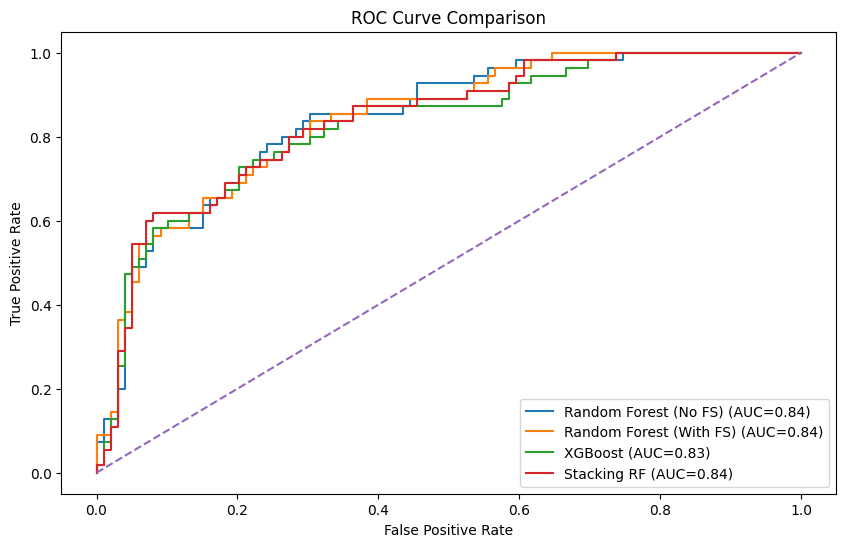

In [31]:
models = [rf_best, rf_rfe_best, xgb_best, stacking_model]
model_names = ['Random Forest (No FS)', 'Random Forest (With FS)', 'XGBoost', 'Stacking RF']

plt.figure(figsize=(10, 6))
for model, name in zip(models, model_names):
    if name == 'Random Forest (With FS)':
        y_pred_proba = model.predict_proba(X_test_rfe)[:, 1]
    else:
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

### Confusion Matrices
The confusion matrix shows that Random Forest with Feature Selection and XGBoost perform the best at identifying True Positives and True Negatives but struggle with False Negatives and False Positives

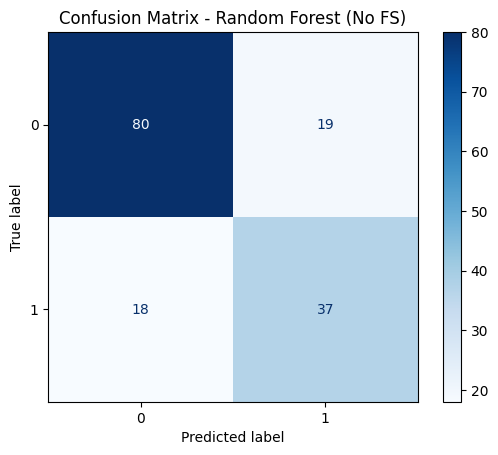

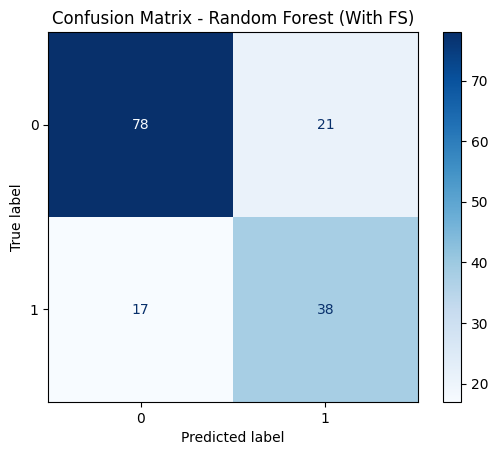

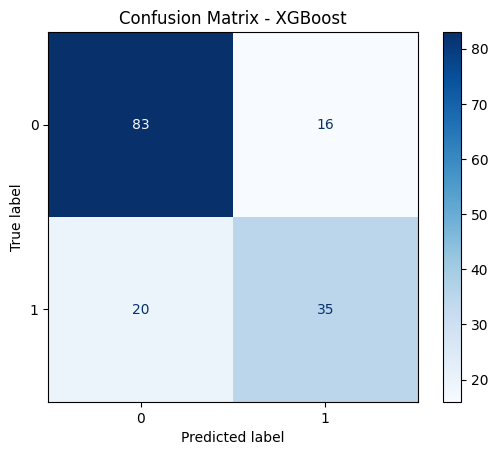

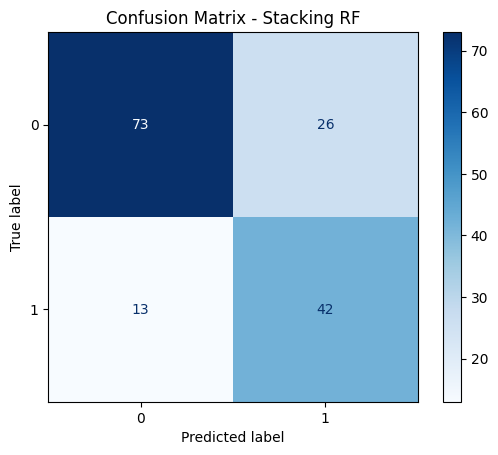

In [32]:
def plot_confusion_matrix(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title(title)
    plt.show()

for model, name in zip(models, model_names):
    if name == 'Random Forest (With FS)':
        plot_confusion_matrix(model, X_test_rfe, y_test, f"Confusion Matrix - {name}")
    else:
        plot_confusion_matrix(model, X_test_scaled, y_test, f"Confusion Matrix - {name}")

### Model Accuracy comparison
The model accuracy comparison shows that stacking is clearly the most powerful model but the confusion matrix and the low AUC score shows that the model is struggling to differentiate between True and False Positives.These results can be explained by the outcome imbalance in the original dataset

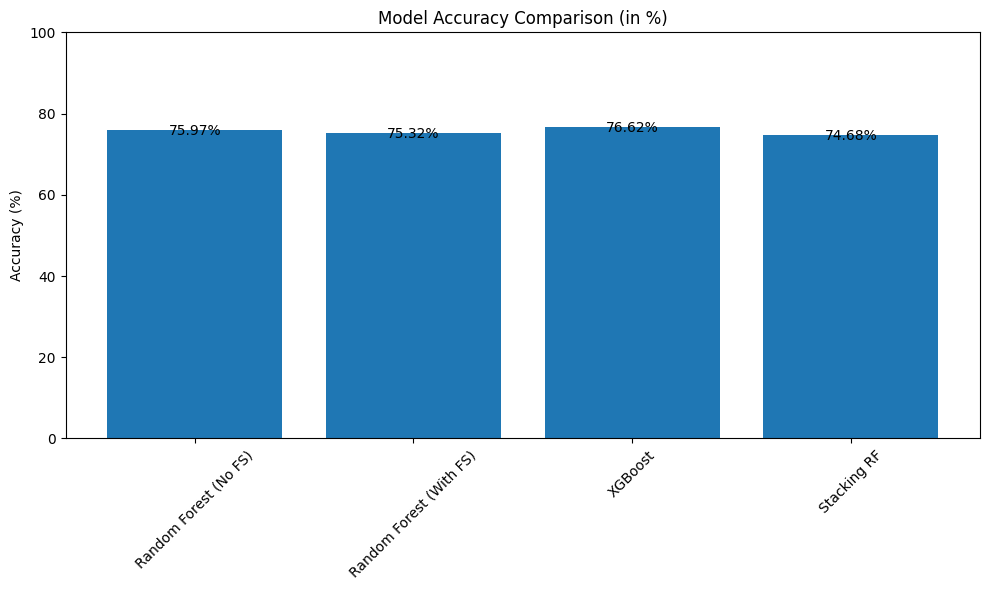

In [33]:
accuracies = [
    accuracy_score(y_test, rf_best.predict(X_test_scaled)) * 100,
    accuracy_score(y_test, rf_rfe_best.predict(X_test_rfe)) * 100,
    accuracy_score(y_test, xgb_best.predict(X_test_scaled)) * 100,
    accuracy_score(y_test, stacking_model.predict(X_test_scaled)) * 100
]

# Plot model accuracies as percentages
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies)
plt.title('Model Accuracy Comparison (in %)')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
for i, v in enumerate(accuracies):
    plt.text(i, v - 2, f'{v:.2f}%', ha='center', va='bottom', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Discussion and Conclusion

Based on the results, it is clear that Stacking RF and other boosting techinques provides a better accuracy than standard Random Forest classifiers. However, it also points to the *importance of preprocessing* the data to achieve higher levels of discrimination between different outcomes. Without enough preprocessing of the data, models tend to learn less and end up relying on majority votes to predict outcomes.

## References

Kaina Zhao and Zhiping Wang. 2024. Research on Diabetes Prediction Based on Machine Learning. In Proceedings of the 6th International Conference on Machine Learning and Machine Intelligence (MLMI '23). Association for Computing Machinery, New York, NY, USA, 29–33. https://doi-org.colorado.idm.oclc.org/10.1145/3635638.3635643

Xi Li, Michele Curiger, Rolf Dornberger, and Thomas Hanne. 2023. Optimized Computational Diabetes Prediction with Feature Selection Algorithms. In Proceedings of the 2023 7th International Conference on Intelligent Systems, Metaheuristics & Swarm Intelligence (ISMSI '23). Association for Computing Machinery, New York, NY, USA, 36–43. https://doi-org.colorado.idm.oclc.org/10.1145/3596947.3596948

Tianqi Chen and Carlos Guestrin. 2016. XGBoost: A Scalable Tree Boosting System. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD '16). Association for Computing Machinery, New York, NY, USA, 785–794. https://doi-org.colorado.idm.oclc.org/10.1145/2939672.2939785